In [1]:
# python -m pip install prophet
# conda install -c conda-forge prophet

In [2]:
# python -m pip install "holidays==0.24"
# python -m pip install "prophet==1.1.2"

In [6]:
import numpy as np             
import pandas as pd            
import matplotlib.pylab as plt 
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import holidays
from prophet import Prophet

c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Dataset GDP

In [7]:
df_gdp=pd.read_csv("../../datasets_dw/Ahmed/dataset GDP.csv", skiprows=[0,1,2])
df_gdp=df_gdp.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).iloc[:,:-1]
df_gdp=df_gdp.rename(columns={'Country Name':'Country'})
df_gdp.loc[df_gdp['Country'] == 'Congo, Dem. Rep.', 'Country'] = "DR Congo"
df_gdp.loc[df_gdp['Country'] == 'Viet Nam', 'Country'] = "Vietnam"
df_gdp.loc[df_gdp['Country'] == 'Turkiye', 'Country'] = "Turkey"
df_gdp.loc[df_gdp['Country'] == 'Korea, Rep.', 'Country'] = "South Korea"
df_gdp.loc[df_gdp['Country'] == "Cote d'Ivoire", 'Country'] = "Ivory Coast"
df_gdp.loc[df_gdp['Country'] == 'Czechia', 'Country'] = "Czech Republic"
df_gdp.loc[df_gdp['Country']=="Lao PDR","Country"]="Laos"
df_gdp.loc[df_gdp['Country']=="Congo, Rep.","Country"]="Republic of the Congo"
df_gdp.loc[df_gdp['Country'] == 'Slovak Republic', 'Country'] = "Slovakia"
df_gdp.loc[df_gdp['Country'] == 'Macao SAR, China', 'Country'] = "Macau"
df_gdp.loc[df_gdp['Country'] == 'Cabo Verde', 'Country'] = "Cape Verde"
df_gdp.loc[df_gdp['Country'] == 'St. Lucia', 'Country'] = "Saint Lucia"
df_gdp.loc[df_gdp['Country'] == 'St. Vincent and the Grenadines', 'Country'] = "Saint Vincent and the Grenadines"
df_gdp.loc[df_gdp['Country'] == 'St. Kitts and Nevis', 'Country'] = "Saint Kitts and Nevis"

df=pd.read_csv("../../datasets_merged/df_mergedFinal.csv")
df_contient_country=df.loc[:,['Country', 'Continent']]
df_gdp=pd.merge(df_contient_country, df_gdp, on='Country' )

df_gdpT=df_gdp.transpose()
df_gdpT=df_gdpT.reset_index()
df_gdpT.columns=["ds"]+list(df_gdpT.iloc[0,1:])
continents=df_gdpT.iloc[1,1:]

# Supprimer les lignes des pays et continents pour ne garder que la date et les GDP
df_gdpT=df_gdpT.iloc[2:,:]
df_gdpT

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Vietnam,Zambia,Zimbabwe
2,1960,537777811.111111,NaN,2723615451.30098,NaN,NaN,NaN,NaN,NaN,18606562977.050098,...,NaN,NaN,73233967692.102798,543300000000.0,1208333333.33333,NaN,NaN,NaN,713000000.0,1052990400.0
3,1961,548888895.555556,NaN,2434747055.94018,NaN,NaN,NaN,NaN,NaN,19682883149.261299,...,NaN,NaN,77741965703.354401,563300000000.0,1600000000.0,NaN,NaN,NaN,696285714.285714,1096646600.0
4,1962,546666677.777778,NaN,2001444543.91885,NaN,NaN,NaN,NaN,NaN,19922563187.6101,...,NaN,NaN,81247564156.8246,605100000000.0,1763636363.63636,NaN,NaN,NaN,693142857.142857,1117601600.0
5,1963,751111191.111111,NaN,2702982017.63803,NaN,NaN,NaN,NaN,NaN,21539843446.375,...,NaN,NaN,86561961812.324905,638600000000.0,1553333333.33333,NaN,NaN,NaN,718714285.714286,1159511700.0
6,1964,800000044.444444,NaN,2909316435.2874,NaN,NaN,NaN,NaN,NaN,23801123808.179798,...,NaN,NaN,94407558351.161606,685800000000.0,1970588235.29412,NaN,NaN,NaN,839428571.428571,1217138000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2018,18053222734.8881,15156424015.197701,174910684781.571014,3218418631.67579,79450688232.001099,1661529629.62963,524819892360.176025,12457940694.7395,1429733668185.909912,...,130891088293.550003,427049432149.344971,2871340347581.790039,20533057312000.0,65203071817.981201,52870108217.294899,914736985.430944,310106478394.658997,26311507273.6735,34156069918.060902
61,2019,18799444414.5998,15401826127.253901,171760275466.609985,3155150255.91195,70897962712.621307,1725351851.85185,447754683615.224976,13619290539.211599,1394671325960.570068,...,153883047509.576996,417989721734.494019,2851407164907.810059,21380976119000.0,62048585618.504997,60283503705.390701,936526267.622513,334365270496.666992,23308667781.2258,21832234921.176201
62,2020,19955929060.841,15162734205.246201,145743542982.627991,2891002460.29153,48501561230.000999,1410796296.2963,385740508436.965027,12641698583.2152,1330381544909.300049,...,156617722013.34201,349473015336.939026,2697806592293.859863,21060473613000.0,53666908053.765503,60224701296.788498,909421043.508407,346615738537.796021,18110638269.223801,21509698406.6618
63,2021,14266499429.874599,17930565118.8176,163472387986.768005,3325143693.28714,66505129989.242996,1601366666.66667,487902572164.348022,13878908628.937799,1559033756285.129883,...,199765859570.934998,415178792769.883972,3141506156618.700195,23315080560000.0,61412268248.946098,69600614987.350906,971636097.850666,366137569122.215027,22096416933.790199,28371238665.864601


In [8]:
pays='France'
annee_souverainete=list(df[df.loc[:,'Country']==pays]['Annee_Souverainete'])[0]
df_france=df_gdpT.loc[:,['ds', pays]]
df_france.rename(columns={pays:'y'}, inplace=True)
df_france.y=df_france.y/annee_souverainete
df_france

,ds,y
2,1960,73814327.403182
3,1961,80025675.233731
4,1962,89688647.461363
5,1963,100544715.428077
6,1964,111515837.541362
...,...,...
60,2018,3310743628.406477
61,2019,3237094005.582301
62,2020,3140472943.770403
63,2021,3510505123.571174


In [9]:
pays='Singapore'
annee_souverainete=list(df[df.loc[:,'Country']==pays]['Annee_Souverainete'])[0]
df_singapore=df_gdpT.loc[:,['ds', pays]]
df_singapore.rename(columns={pays:'y'}, inplace=True)
df_singapore.y=df_singapore.y/annee_souverainete
df_singapore=df_singapore
df_singapore

,ds,y
2,1960,359750.740328
3,1961,390316.379849
4,1962,421765.804909
5,1963,468406.336137
6,1964,456433.543351
...,...,...
60,2018,192378505.614093
61,2019,192362215.618979
62,2020,177841802.294649
63,2021,216333384.646021


In [10]:
df=df_france.copy()

In [11]:
df['ds']=pd.to_datetime(df.ds)

In [12]:
indexedDataset=df.set_index('ds')
indexedDataset

,y
ds,
1960-01-01,73814327.403182
1961-01-01,80025675.233731
1962-01-01,89688647.461363
1963-01-01,100544715.428077
1964-01-01,111515837.541362
...,...
2018-01-01,3310743628.406477
2019-01-01,3237094005.582301
2020-01-01,3140472943.770403


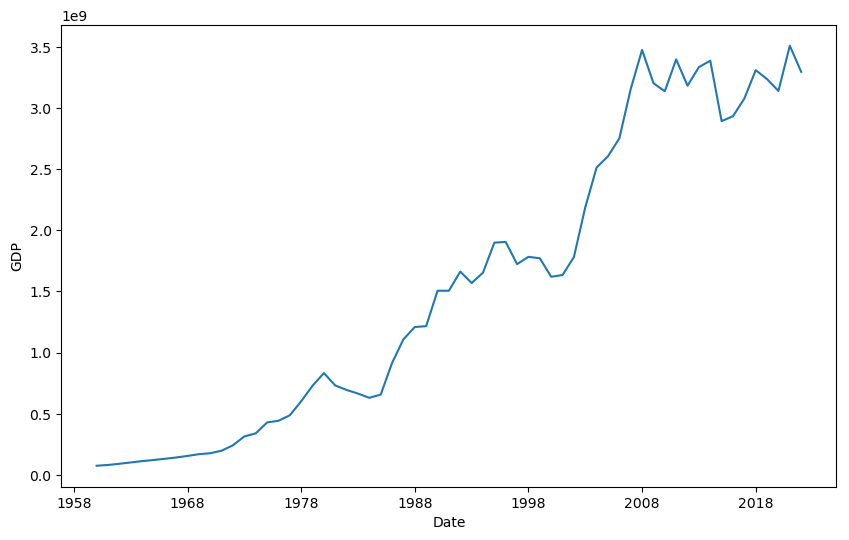

In [13]:
# Visualiser les données
plt.xlabel('Date')
plt.ylabel('GDP')
plt.plot(indexedDataset)

## ARIMA

## Analyse des données

In [14]:
# Calculer la moyenne et l'écart type sur une fenetre de taille ft
ft=5
rolmean = indexedDataset.rolling(window=ft).mean() 
rolstd = indexedDataset.rolling(window=ft).std()
# print(rolmean,rolstd)

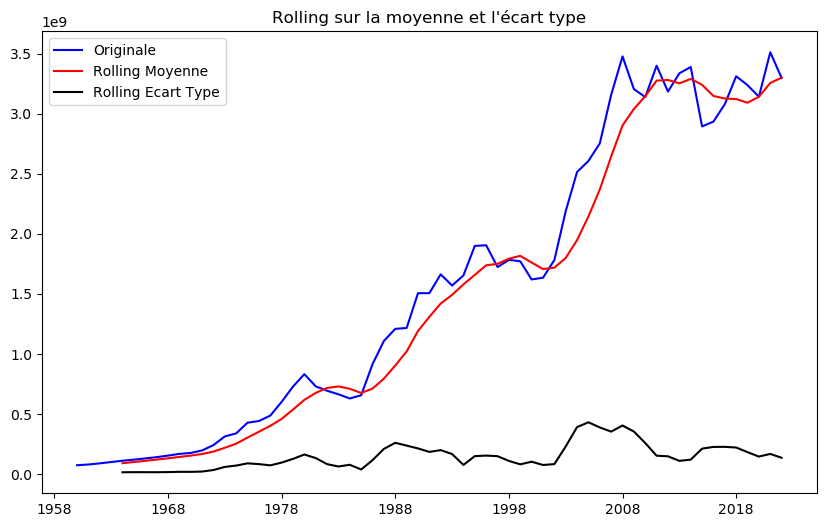

In [15]:
orig = plt.plot(indexedDataset, color='blue', label='Originale')
mean = plt.plot(rolmean, color='red', label='Rolling Moyenne')
std = plt.plot(rolstd, color='black', label='Rolling Ecart Type')
plt.legend(loc='best')
plt.title("Rolling sur la moyenne et l'écart type")
plt.show(block=False)

### Passage au Log

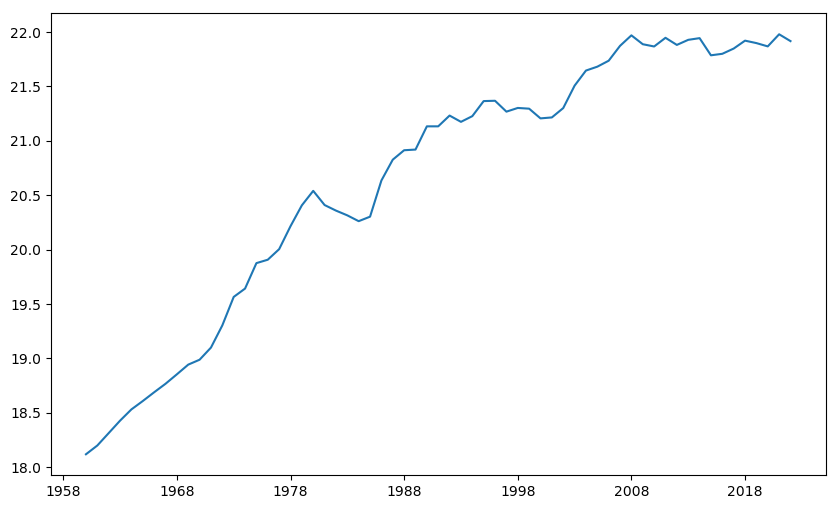

In [16]:
# Convertir les données en entiers pour pouvoir appliquer le log
indexedDataset=indexedDataset.astype('int64')
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

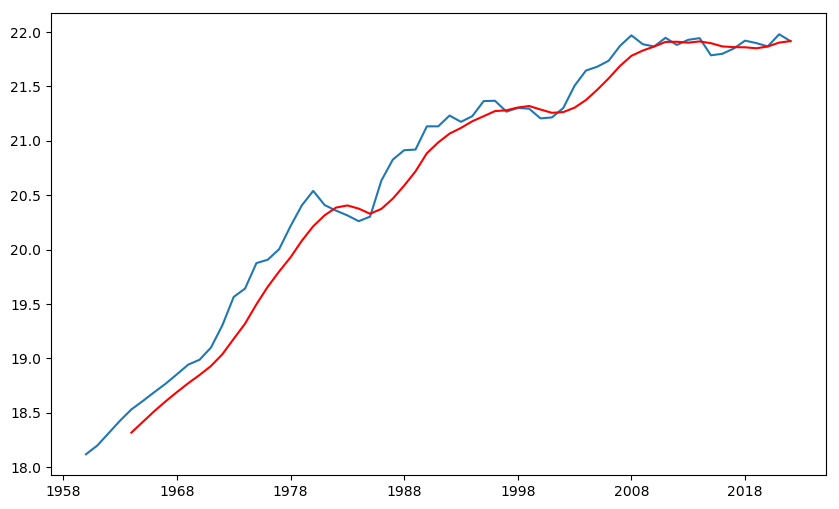

In [17]:
# Visualisation des données avec un rolling moyenne
movingAverage = indexedDataset_logScale.rolling(window=ft).mean()
movingSTD = indexedDataset_logScale.rolling(window=ft).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [18]:
# Soustraire la moyenne fenetrée (pour éliminer la trend)
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage

# Supprimer les NANs
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

In [19]:
def test_stationarity(timeseries, ft=3):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=ft).mean()
    movingSTD = timeseries.rolling(window=ft).std()
    
    # Afficher les statistiques sur le rolling
    orig = plt.plot(timeseries, color='blue', label='Originale')
    mean = plt.plot(movingAverage, color='red', label='Rolling Moyenne')
    std = plt.plot(movingSTD, color='black', label='Rolling Ecart type')
    plt.legend(loc='best')
    plt.title("Rolling sur la moyenne et l'écart type")
    plt.show(block=False)
    
    # Appliquer le teste de Dickey–Fuller
    print('Résultats du teste de Dickey Fuller')
    dftest = adfuller(timeseries['y'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',"Nombre d'instances"])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

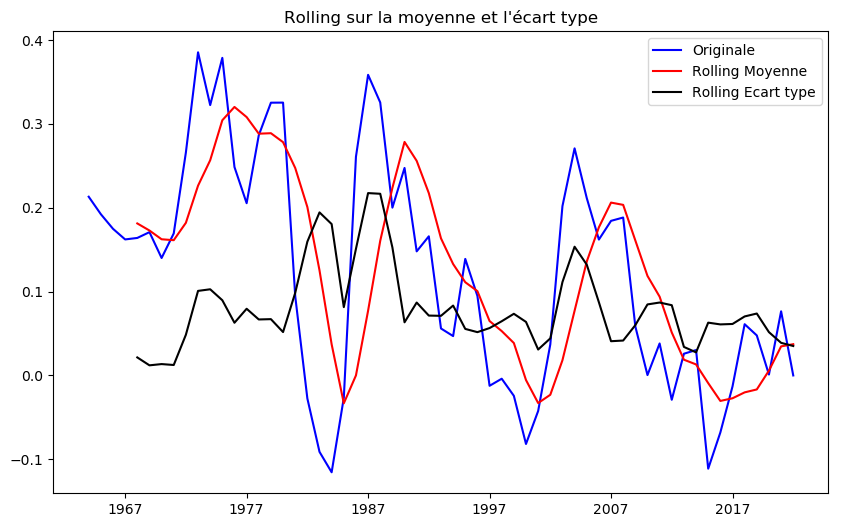

Résultats du teste de Dickey Fuller
Test Statistic          -3.294298
p-value                  0.015135
#Lags Used               1.000000
Nombre d'instances      57.000000
Critical Value (1%)     -3.550670
Critical Value (5%)     -2.913766
Critical Value (10%)    -2.594624
dtype: float64


In [20]:
test_stationarity(datasetLogScaleMinusMovingAverage, ft=ft)

### Analyse des composantes de la série temporelle

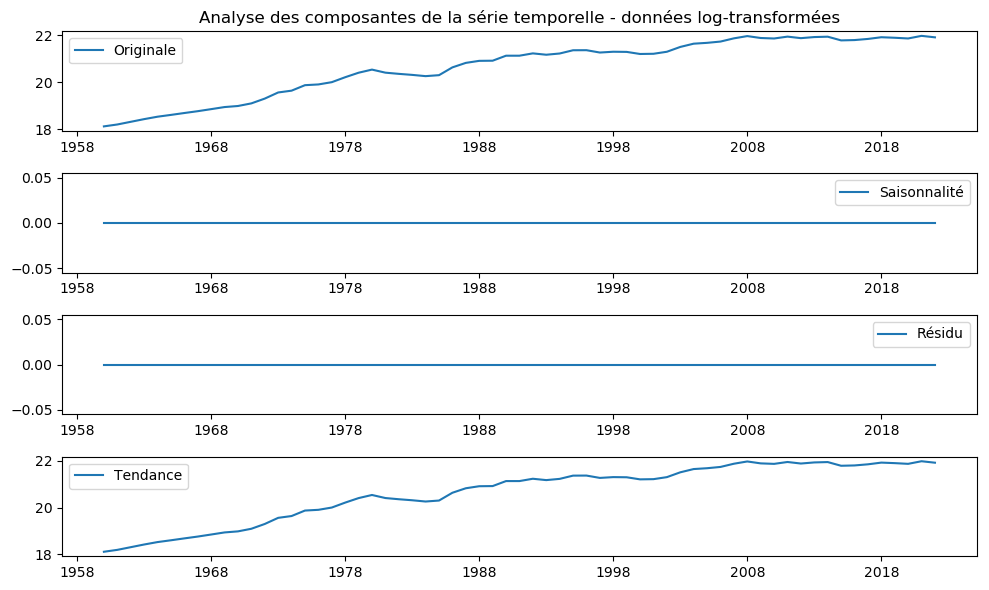

In [21]:
# Analyse des tendances, saisonnalité et residuals sur les données log-transformées
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)

plt.title("Analyse des composantes de la série temporelle - données log-transformées")
plt.plot(indexedDataset_logScale, label='Originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(residual, label='Résidu')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.tight_layout()


Nous observons des données de seasonality et residuals à 0, cela est très probalement du au manque de données, il est difficile pour l'algorithme de décomposition de détecter des tendances et des motifs saisonniers significatifs.

c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\Users\racha\anaconda3\envs\python_39\lib\

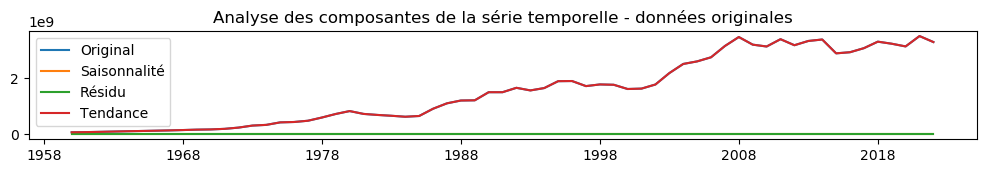

In [22]:
# Analyse des tendances, saisonnalité et residuals sur les données originales
decomposition = seasonal_decompose(indexedDataset) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)

plt.title("Analyse des composantes de la série temporelle - données originales")
plt.plot(indexedDataset, label='Original')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Résidu')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.tight_layout()


### Etude de l'ACF et PACF

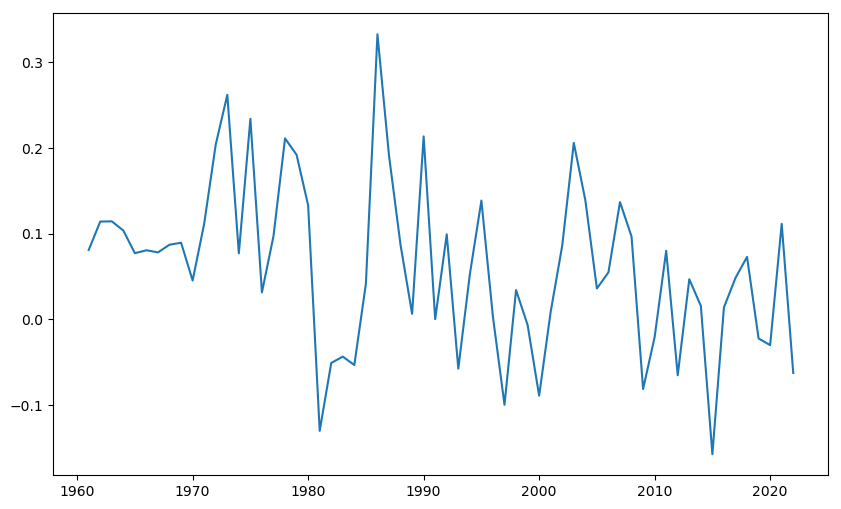

In [23]:
# Décaler l'index d'une position (d'un an)
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() 
plt.plot(datasetLogDiffShifting)

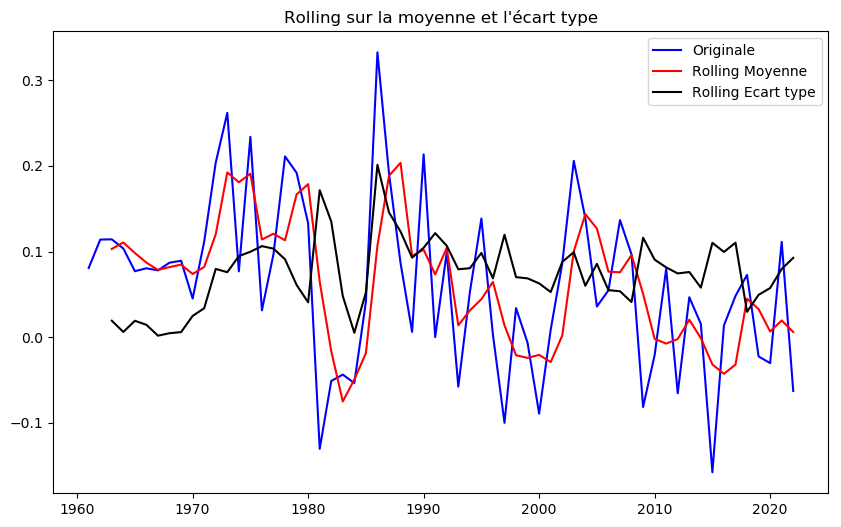

Résultats du teste de Dickey Fuller
Test Statistic          -5.440434
p-value                  0.000003
#Lags Used               0.000000
Nombre d'instances      61.000000
Critical Value (1%)     -3.542413
Critical Value (5%)     -2.910236
Critical Value (10%)    -2.592745
dtype: float64


In [24]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

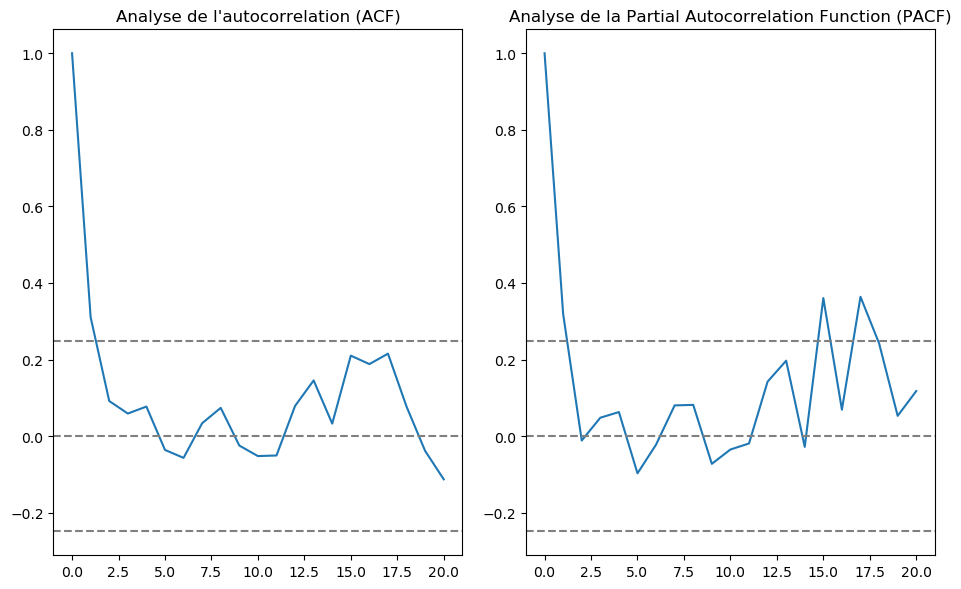

In [25]:
acf_val = acf(datasetLogDiffShifting, nlags=20)
pacf_val = pacf(datasetLogDiffShifting, nlags=20, method='ols')

# Afficher l'ACF
plt.subplot(121)
plt.plot(acf_val)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title("Analyse de l'autocorrelation (ACF)")            

# Afficher la PACF
plt.subplot(122)
plt.plot(pacf_val)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title("Analyse de la Partial Autocorrelation Function (PACF)")
            
plt.tight_layout()         

## Appliquer le modèle ARIMA

c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


RSS= 328.8046


Text(0.5,1,'AR model')

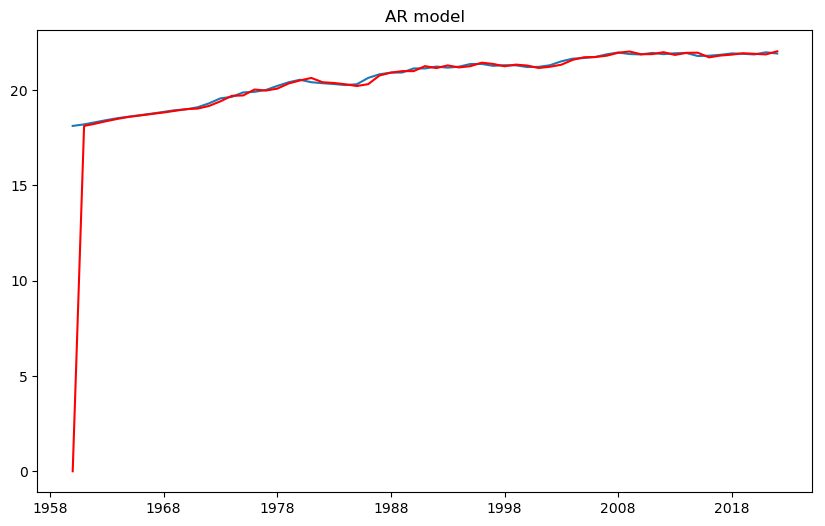

In [26]:
#AR modèle
model = ARIMA(indexedDataset_logScale, order=(5,1,0))
results_AR = model.fit()
plt.plot(indexedDataset_logScale)
plt.plot(results_AR.fittedvalues, color='red')

print('RSS= %.4f'%sum((results_AR.fittedvalues - indexedDataset_logScale['y'])**2))
plt.title('AR model')

RSS= 328.8591


c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Text(0.5,1,'MA model')

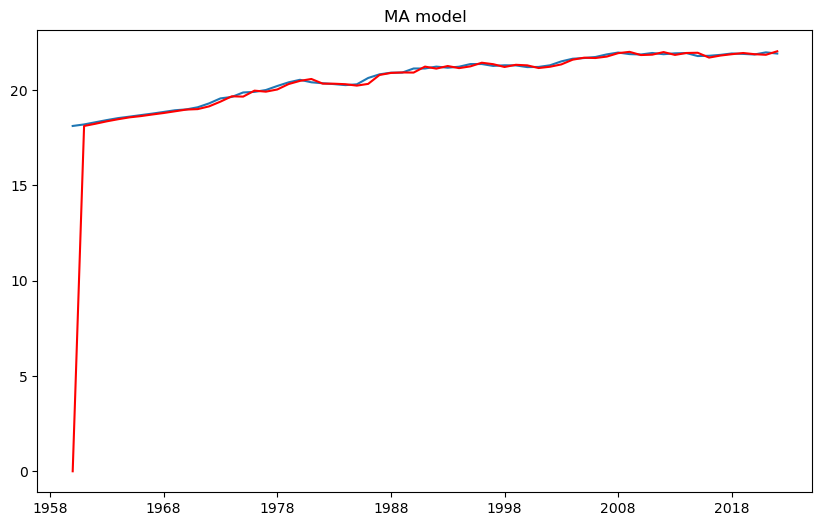

In [27]:
#MA modèle
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit()
plt.plot(indexedDataset_logScale)
plt.plot(results_MA.fittedvalues, color='red')
print('RSS= %.4f'%sum((results_MA.fittedvalues - indexedDataset_logScale['y'])**2))
plt.title('MA model')

c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


RSS: 328.7730


c:\Users\racha\anaconda3\envs\python_39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5,1,'ARIMA model')

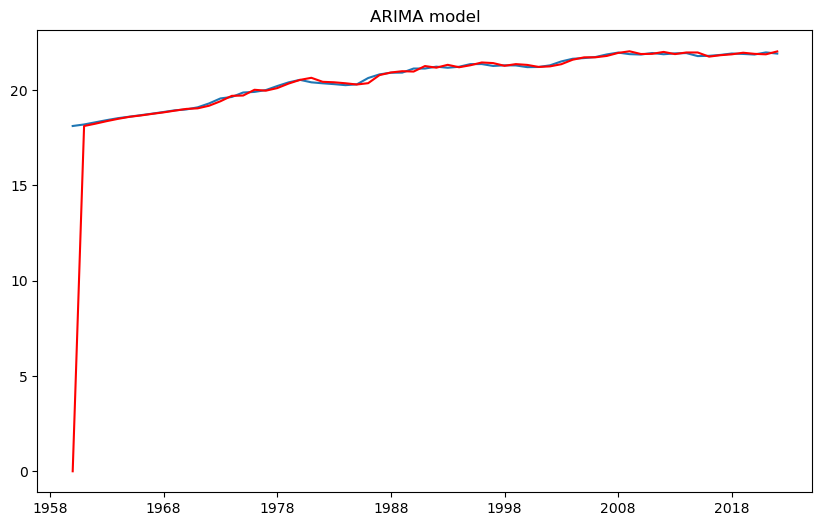

In [28]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(5,1,2))
results_ARIMA = model.fit()
plt.plot(indexedDataset_logScale)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('RSS: %.4f'%sum((results_ARIMA.fittedvalues - indexedDataset_logScale['y'])**2))
plt.title('ARIMA model')

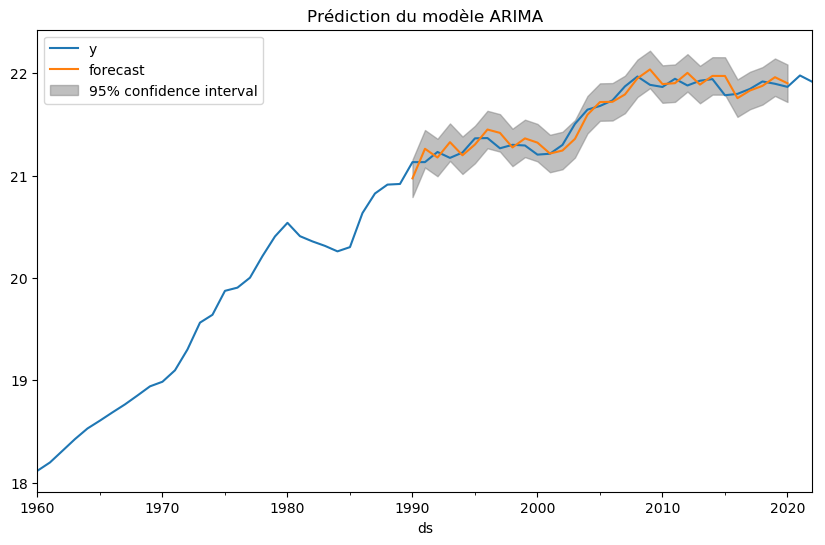

In [29]:
fig, ax = plt.subplots()
ax = indexedDataset_logScale.loc['1950':].plot(ax=ax)
plot_predict(results_ARIMA, '1990', '2020', ax=ax)
plt.title('Prédiction du modèle ARIMA')
plt.show()

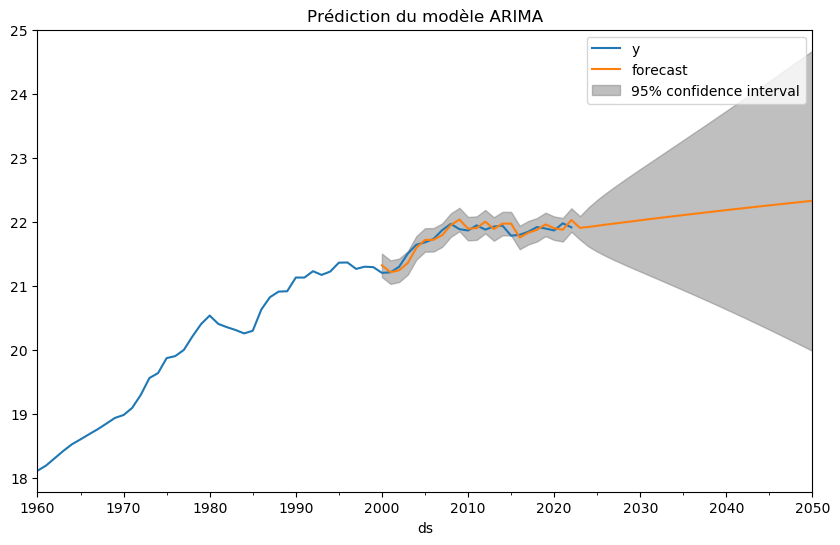

In [30]:
fig, ax = plt.subplots()
ax = indexedDataset_logScale.loc['1950':].plot(ax=ax)
plot_predict(results_ARIMA, '2000', '2050', ax=ax)
plt.title('Prédiction du modèle ARIMA')
plt.show()

## Prophet

In [31]:
# Appliquer le log aux données (pour une meilleure adaptation du modèle)
df_france.y=np.log(df_france.y.astype('int64'))
df_singapore.y=np.log(df_singapore.y.astype('int64'))

In [32]:
# Instancier le modèle Prophet
prophet_model_fr = Prophet()
prophet_model_fr.fit(df_france)

prophet_model_sing = Prophet()
prophet_model_sing.fit(df_singapore)

20:03:18 - cmdstanpy - INFO - Chain [1] start processing
20:03:19 - cmdstanpy - INFO - Chain [1] done processing
20:03:19 - cmdstanpy - INFO - Chain [1] start processing
20:03:20 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# Construire le dataset correspondant aux 10 prochaines années
future = prophet_model_fr.make_future_dataframe(periods=365*20)
future=future[future["ds"].dt.day==1]
future=future[future['ds'].dt.month==1 ]
future.tail()

,ds
5541,2037-01-01
5906,2038-01-01
6271,2039-01-01
6636,2040-01-01
7002,2041-01-01


In [34]:
# Prédire l'indice évolution sur les 10 prochaines années
forecast_fr = prophet_model_fr.predict(future)
forecast_fr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
77,2037-01-01,21.894481,20.891709,22.985257
78,2038-01-01,21.916219,20.790039,23.093321
79,2039-01-01,21.926422,20.689610,23.220085
80,2040-01-01,21.924578,20.551207,23.368852
81,2041-01-01,21.898061,20.398994,23.431398


In [35]:
# Prédire l'indice évolution sur les 10 prochaines années
forecast_sing = prophet_model_sing.predict(future)
forecast_sing[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
77,2037-01-01,20.049640,19.214441,20.954593
78,2038-01-01,20.110813,19.162208,21.128723
79,2039-01-01,20.168947,19.119886,21.282713
80,2040-01-01,20.223820,19.035132,21.429830
81,2041-01-01,20.263531,19.019375,21.570827


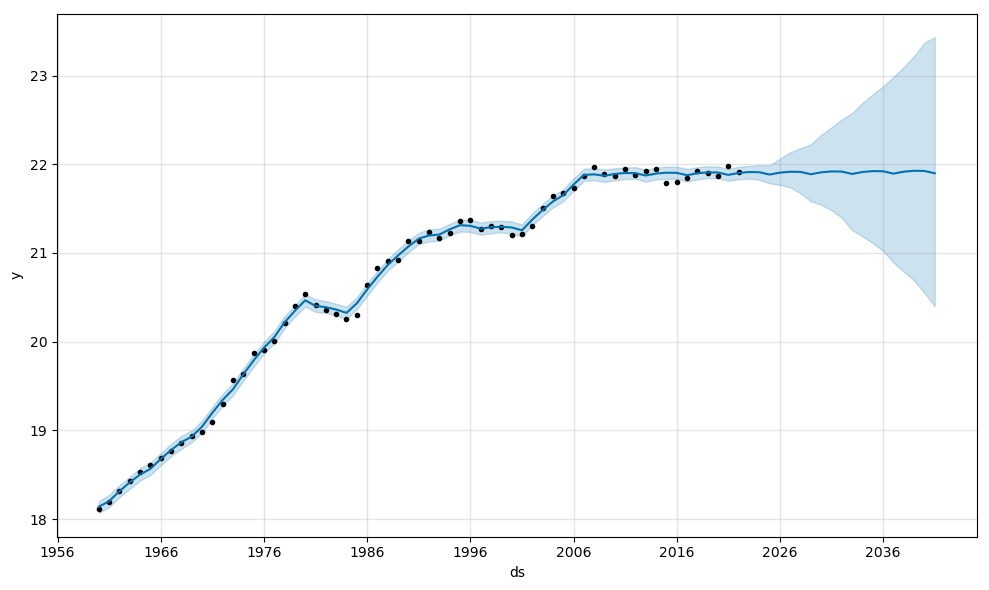

In [36]:
fig1_fr = prophet_model_fr.plot(forecast_fr)

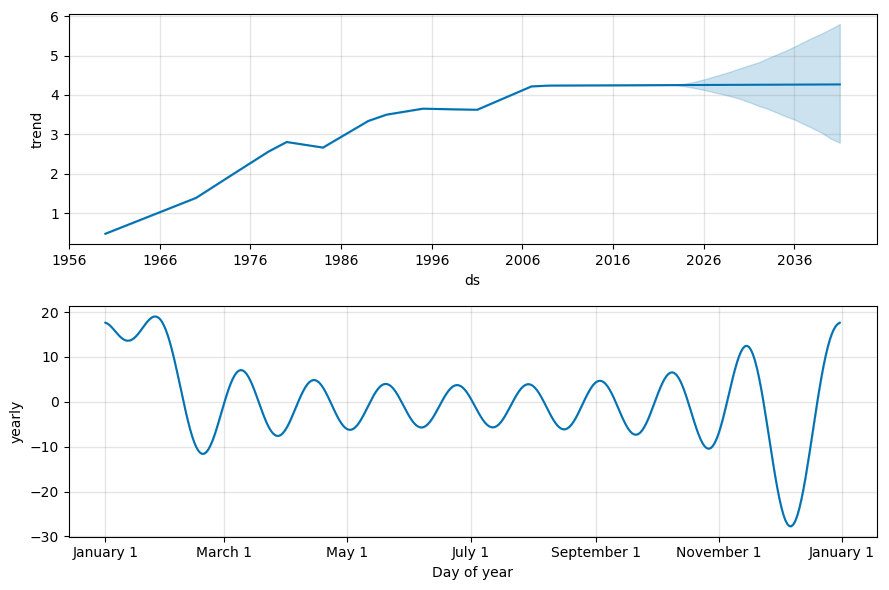

In [37]:
# Visualiser la tendance globale/ annuelle
fig2_fr = prophet_model_fr.plot_components(forecast_fr)

On peut remarquer une tendance mensuelle nulle car le modèle ne possède que les données du 01 janvier de chaque année

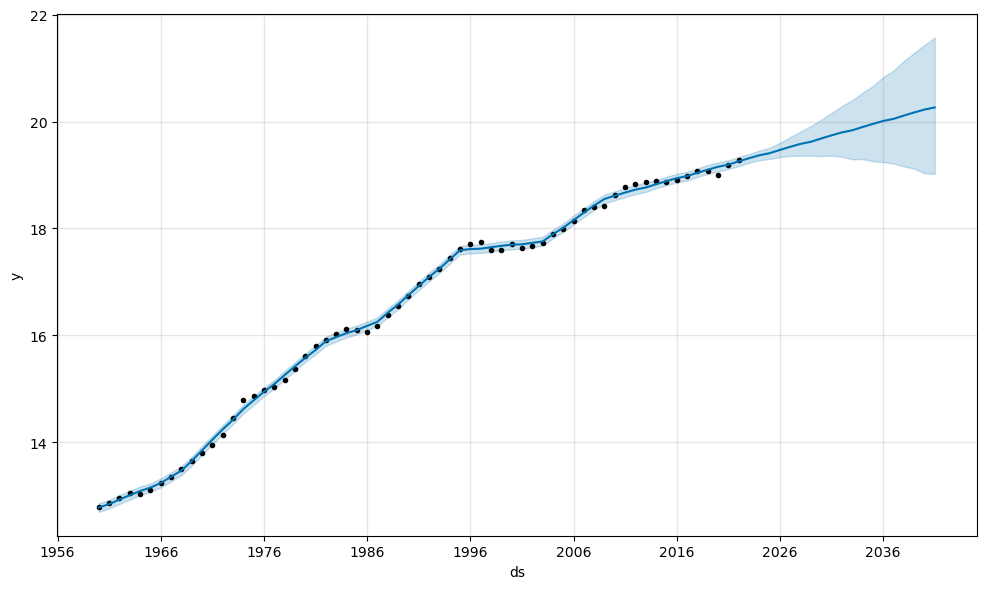

In [38]:
fig1_sing = prophet_model_sing.plot(forecast_sing)

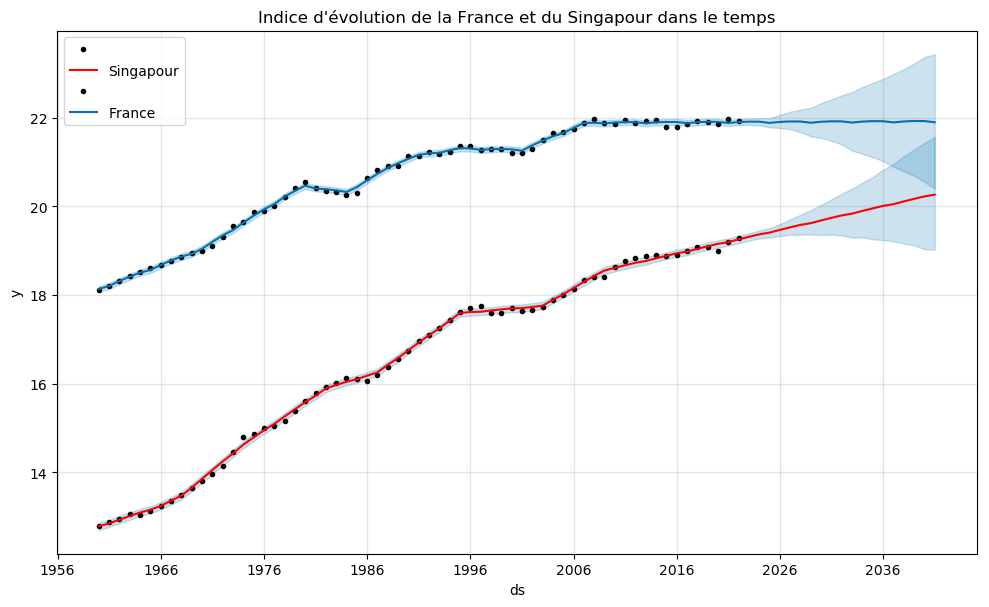

In [41]:
plt.figure(figsize=(10, 6)) 

prophet_model_sing.plot(forecast_sing, ax=plt.gca()) 

prophet_model_fr.plot(forecast_fr, ax=plt.gca()) 
plt.gca().get_lines()[1].set_color('red')  # Courbe pour la France 

plt.legend([" ","Singapour", " ","France"])
plt.title("Indice d'évolution de la France et du Singapour dans le temps")
plt.show()